# Digital Recognizer (MNIST) - Kaggle

Standard configuration

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import from libraries

In [5]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy,error_rate

Custom function to read the .csv files. Credits to [Steven Testa](https://www.kaggle.com/c/digit-recognizer/discussion/80243)

In [6]:
class CustomImageItemList(ImageItemList):
    def open(self, fn):
        img = fn.reshape(28,28)
        img = np.stack((img,)*3, axis=-1) # convert to 3 channels
        return Image(pil2tensor(img, dtype=np.float32))

    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, imgIdx:int=1, header:str='infer', **kwargs)->'ItemList':
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        # convert pixels to an ndarray
        res.items = df.iloc[:,imgIdx:].apply(lambda x: x.values / 255.0, axis=1).values
        return res

Set the path to the data set

In [7]:
true_path = '/home/pedroitumbawow/data/digit-recognizer-data/'
true_path

'/home/pedroitumbawow/data/digit-recognizer-data/'

Loading data sets

In [10]:
test = CustomImageItemList.from_csv_custom(path=true_path, csv_name='test.csv', imgIdx=0)

data = (CustomImageItemList.from_csv_custom(path=true_path, csv_name='train.csv')
                       .random_split_by_pct(.2)
                       .label_from_df(cols='label')
                       .add_test(test, label=0)
                       .databunch(bs=64))

### Resnet 34
Creating and training a Convolutional Neural Network (CNN)

In [27]:
learn = create_cnn(data, models.resnet34, metrics=[accuracy,error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02


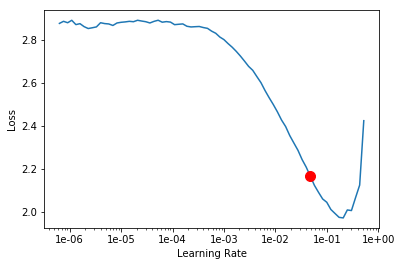

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
first_lr = 1e-02

In [30]:
learn.fit_one_cycle(5, slice(first_lr))

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.502849,0.312284,0.900357,0.099643
2,0.214730,0.128486,0.959762,0.040238
3,0.122844,0.069618,0.977976,0.022024
4,0.088757,0.054248,0.982738,0.017262
5,0.069354,0.052835,0.983452,0.016548


In [31]:
learn.save('r34-stage1')

Finding a better learning rate

In [33]:
learn.load('r34-stage1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06


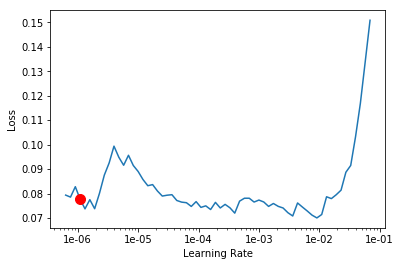

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.unfreeze()

In [36]:
second_lr = 1e-03

In [37]:
learn.fit_one_cycle(3, max_lr=slice(second_lr,first_lr/5))

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.106340,0.100254,0.972024,0.027976
2,0.055093,0.042892,0.986786,0.013214
3,0.018225,0.030690,0.991905,0.008095


In [40]:
# get the predictions
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
# output to a file
res_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
res_df.to_csv('/home/pedroitumbawow/data/digit-recognizer-data/digit-recognition-submission.csv', index=False)

### Resnet 50
Creating and training a Convolutional Neural Network (CNN)

In [12]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy,error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03


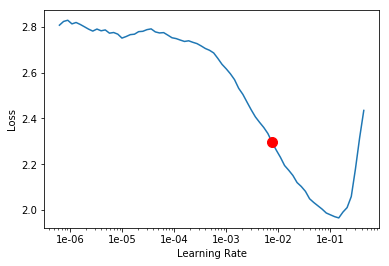

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
first_lr = 1e-02

In [15]:
learn.fit_one_cycle(10, slice(first_lr))

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.609521,0.455451,0.850476,0.149524
2,0.290153,0.171556,0.948571,0.051429
3,0.166309,0.111969,0.965357,0.034643
4,0.113268,0.067253,0.980595,0.019405
5,0.073791,0.051809,0.985952,0.014048
6,0.051241,0.175257,0.985595,0.014405
7,0.041544,0.058479,0.988571,0.011429
8,0.022283,0.054585,0.989048,0.010952
9,0.019383,0.032854,0.990833,0.009167
10,0.010549,0.032240,0.991786,0.008214


In [16]:
learn.save('r50-stage1')

In [18]:
learn.load('r50-stage1');

In [21]:
learn.unfreeze()

In [22]:
second_lr = 1e-03

In [23]:
learn.fit_one_cycle(5, max_lr=slice(second_lr,first_lr/5))

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.121424,0.103938,0.966667,0.033333
2,0.097309,0.059052,0.982143,0.017857
3,0.060693,0.051591,0.985476,0.014524
4,0.026299,0.026665,0.992738,0.007262
5,0.011716,0.024402,0.994405,0.005595


In [25]:
learn.save('r50-stage2')

In [26]:
learn.load('r50-stage1');

In [24]:
# get the predictions
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
# output to a file
res_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
res_df.to_csv('/home/pedroitumbawow/data/digit-recognizer-data/digit-recognition-submission2.csv', index=False)